#**EDA**

In [13]:
!pip install squarify
!pip install tqdm

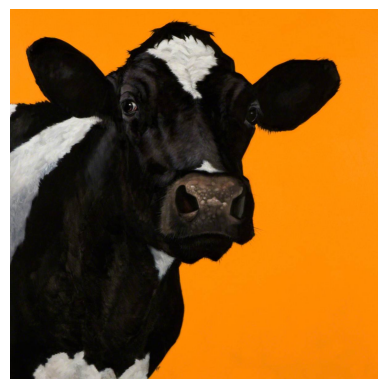

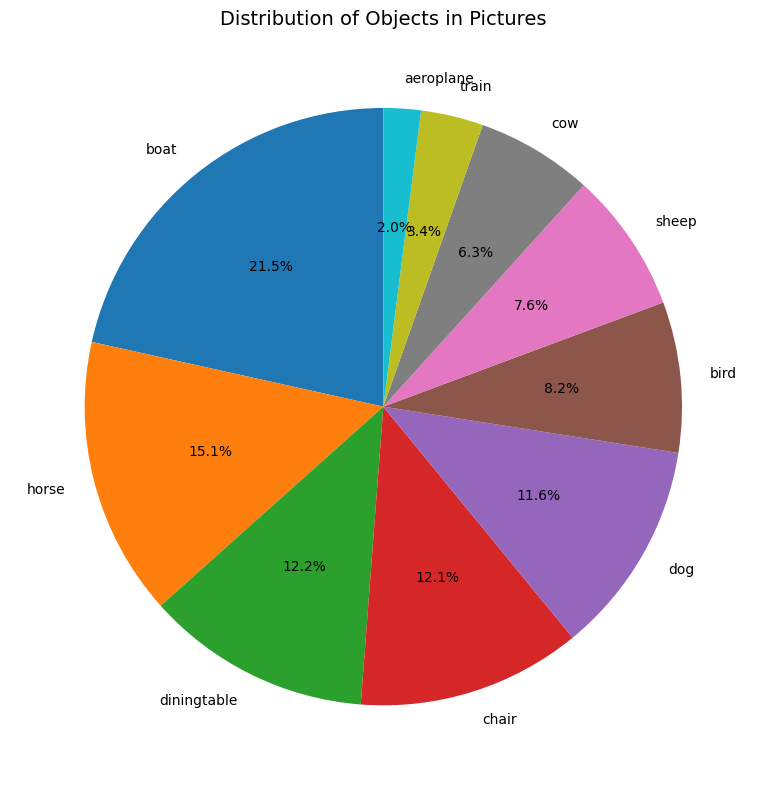

["' cow'" "' train'" "' horse'" "' aeroplane horse'" "' aeroplane'"
 "' chair'" "' chair diningtable dog'" "' bird dog'" "' bird'" "' boat'"
 "' cow horse'" "' dog'" "' chair diningtable'" "' dog horse'"
 "' diningtable'" "' bird diningtable'" "' sheep'" "' boat dog'"
 "' bird boat'" "' bird horse'" "' bird cow dog sheep'" "' cow sheep'"
 "' boat train'" "' cow dog'" "' boat horse'" "' chair dog'"
 "' bird diningtable dog'" "' bird boat cow'" "' cow dog horse sheep'"
 "' bird cow dog horse'" "' dog sheep'" "' bird boat dog horse'"
 "' boat cow dog'" "' cow horse sheep'" "' diningtable dog'"
 "' bird train'" "' bird horse sheep'" "' horse sheep'" "' bird chair'"
 "' bird dog horse'" "' aeroplane boat'" "' sheep train'" "' dog train'"
 "' horse train'" "' bird cow sheep'" "' bird cow'" "' boat diningtable'"
 "' cow dog sheep'" "' cow dog horse'" "' bird sheep'" "' boat cow'"
 "' chair horse'" "' boat cow dog horse'" "' dog horse sheep'"
 "' boat dog horse'" "' chair diningtable horse'" "

In [14]:
# Data handling
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from io import BytesIO
from collections import Counter
from itertools import combinations

# Image processing & requests
import requests
from PIL import Image
from tensorflow.keras.preprocessing import image

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import squarify

# Machine learning / Deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Load your CSV
df = pd.read_csv("/content/painting_dataset_2021.csv")
df = df.dropna(subset=["Image URL"]).reset_index(drop=True)

# Display the first valid image
url = df.loc[0, "Image URL"]
if pd.notna(url) and url.startswith(("http://", "https://")):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
else:
    print(f"Invalid URL: {url}")

# Work with labels
labels = df['Labels']

# Clean up and flatten list of objects
objects = []
for entry in labels:
    entry_clean = str(entry).replace("'", "").strip()
    objects.extend(entry_clean.split())

# Count occurrences
counts = Counter(objects)
df_counts = pd.DataFrame(counts.items(), columns=["Object", "Count"]).sort_values(by="Count", ascending=False)

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    df_counts["Count"],
    labels=df_counts["Object"],
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 10}
)
plt.title("Distribution of Objects in Pictures", fontsize=14)
plt.tight_layout()
plt.show()

# Now this works fine
ferda = df["Labels"].unique()
print(ferda)


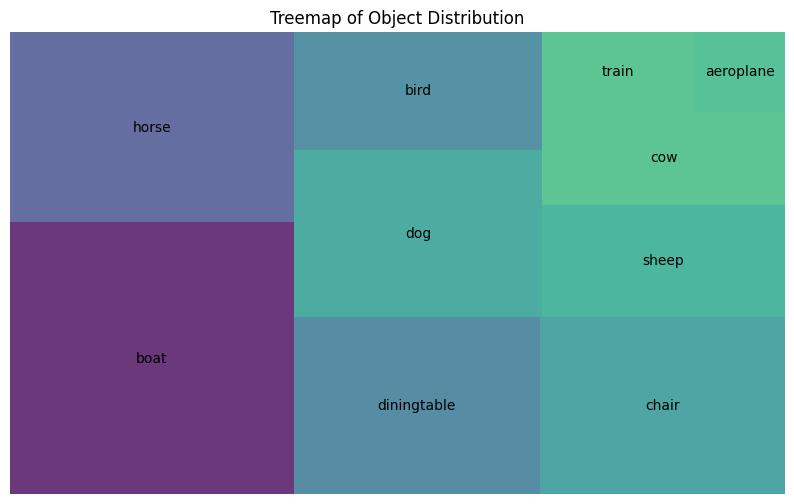

In [19]:
# Build clean object lists per row
plt.figure(figsize=(10, 6))
squarify.plot(
    sizes=df_counts["Count"],
    label=df_counts["Object"],
    alpha=0.8
)
plt.title("Treemap of Object Distribution")
plt.axis('off')
plt.show()

#**LOADING DATA FROM WEB**

In [1]:

# Load CSV
df = pd.read_csv("/content/painting_dataset_2021.csv")

# Get non-empty URLs
urls = df["Image URL"].dropna().tolist()

# Take only the first half
half_count = len(urls) // 4
urls = urls[:half_count]

# Create save directory
save_dir = "/scratch/$USER/images"  # or "/project" if preferred
os.makedirs(save_dir, exist_ok=True)

# Download images
local_paths = []
for i, url in tqdm(enumerate(urls), total=len(urls)):
    filename = os.path.join(save_dir, f"img_{i}.jpg")
    try:
        r = requests.get(url, timeout=10)
        r.raise_for_status()
        with open(filename, "wb") as f:
            f.write(r.content)
        local_paths.append(filename)
    except Exception as e:
        local_paths.append(None)

# Create a smaller dataframe
df_half = df.iloc[:half_count].copy()
df_half["Local Path"] = local_paths

# Drop failed downloads
df_half = df_half.dropna(subset=["Local Path"])

# Save result
df_half.to_csv("images_with_paths_half.csv", index=False)

print(f"✅ Saved {len(df_half)} images to 'images_with_paths_half.csv'")



100%|██████████| 2113/2113 [22:20<00:00,  1.58it/s]

✅ Saved 2113 images to 'images_with_paths_half.csv'


#**SPLITTING TRAINING AND TESTING DATA**

In [17]:

# Load data
df = pd.read_csv("images_with_paths_half.csv")

# Clean up label strings
df["Labels"] = df["Labels"].str.strip().str.replace("'", "").str.strip()

# Drop missing or invalid entries
df = df.dropna(subset=["Local Path", "Labels"])
df = df[df["Local Path"].apply(os.path.exists)]  # ensure file exists

print(f"✅ Loaded {len(df)} valid images with labels")

# ----------------------------
#  Train / Test Split
# ----------------------------
label_counts = df["Labels"].value_counts()
df = df[df["Labels"].isin(label_counts[label_counts > 1].index)]
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["Labels"])

# ----------------------------
#  Data Generators
# ----------------------------
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    zoom_range=0.2
)
test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_dataframe(
    dataframe=train_df,
    x_col="Local Path",
    y_col="Labels",
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=32
)

test_data = test_gen.flow_from_dataframe(
    dataframe=test_df,
    x_col="Local Path",
    y_col="Labels",
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=32
)

# ----------------------------
#  Model: MobileNetV2 (Transfer Learning)
# ----------------------------
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # freeze pretrained layers

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(train_data.class_indices), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])




✅ Loaded 1056 valid images with labels
Found 834 validated image filenames belonging to 30 classes.
Found 209 validated image filenames belonging to 23 classes.


#**MODEL PERFORMANCE METRICS AND ANALYSIS**

🧩 Found 30 total object classes.
Found 834 validated image filenames belonging to 30 classes.
Found 209 validated image filenames belonging to 30 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.1181 - loss: 3.2224 - val_accuracy: 0.1531 - val_loss: 2.6696
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.1725 - loss: 2.6319 - val_accuracy: 0.2057 - val_loss: 2.5926
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.2095 - loss: 2.5120 - val_accuracy: 0.2010 - val_loss: 2.5581
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.2310 - loss: 2.4274 - val_accuracy: 0.1818 - val_loss: 2.5449
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.2907 - loss: 2.2904 - val_accuracy: 0.1962 - val_loss: 2.5298
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.2472 - loss: 2.4343 - val_accuracy: 0.1675 - val_loss: 2.6060
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.2850 - loss: 2.2172 - val_accuracy: 0.1770 - val_loss: 2.5641
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.3142 - loss: 2.1310 - val_accuracy: 0.1722 - val_loss:

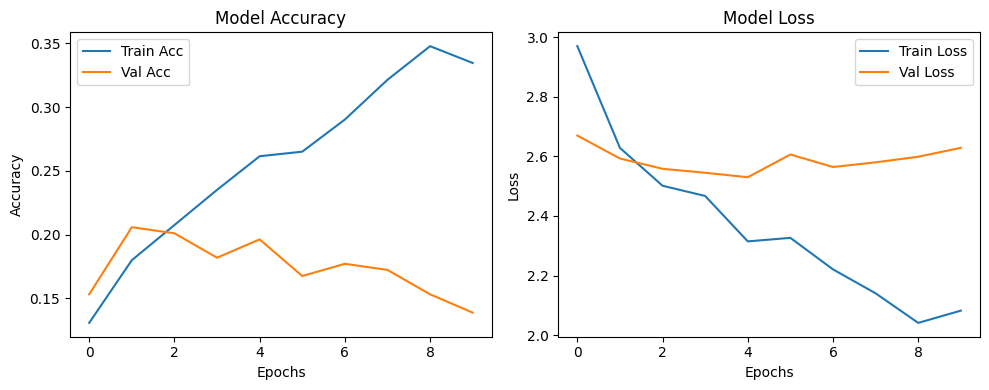


🎨 Sample predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
🖼 img_749.jpg | True: chair diningtable | Predicted: dog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
🖼 img_2045.jpg | True: bird | Predicted: horse
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
🖼 img_493.jpg | True: horse | Predicted: boat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
🖼 img_775.jpg | True: horse | Predicted: boat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


🖼 img_1635.jpg | True: chair | Predicted: horse
💾 Model saved to 'object_classifier.h5'


In [18]:
# ----------------------------
# Train model
# ----------------------------

#  ensure consistent class mapping between train/test
classes = sorted(df["Labels"].unique().tolist())
print(f"🧩 Found {len(classes)} total object classes.")

train_data = train_gen.flow_from_dataframe(
    dataframe=train_df,
    x_col="Local Path",
    y_col="Labels",
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=32,
    classes=classes  #  same class order
)

test_data = test_gen.flow_from_dataframe(
    dataframe=test_df,
    x_col="Local Path",
    y_col="Labels",
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=32,
    classes=classes  #  same class order
)

#  update output layer to match total number of classes
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(classes), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=10
)

# ----------------------------
# Evaluate performance
# ----------------------------
loss, acc = model.evaluate(test_data)
print(f"✅ Test Accuracy: {acc:.3f}")

# ----------------------------
#  Visualize accuracy & loss
# ----------------------------
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

# ----------------------------
# Predict sample images
# ----------------------------
inv_map = {v: k for k, v in train_data.class_indices.items()}

def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0) / 255.0
    preds = model.predict(x)
    pred_label = inv_map[np.argmax(preds)]
    return pred_label

print("\n🎨 Sample predictions:")
sample = test_df.sample(5, random_state=42)
for _, row in sample.iterrows():
    true_label = row["Labels"]
    pred_label = predict_image(row["Local Path"])
    print(f"🖼 {os.path.basename(row['Local Path'])} | True: {true_label} | Predicted: {pred_label}")

# ----------------------------
# Save trained model
# ----------------------------
model.save("object_classifier.h5")
print("💾 Model saved to 'object_classifier.h5'")
